In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_state = 42
np.random.seed(random_state)

In [78]:
url = './written-test-2023-01-09-exam-data.csv'
target = 'target'
names = ['Gender', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', target]
df0 = pd.read_csv(url, names=names, index_col=0)

In [4]:
df0.head()

,Gender,F1,F2,F3,F4,F5,F6,F7,target
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0
1,M,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0
2,F,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0
3,M,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0
4,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0


In [79]:
print('there are {} samples, with {} features'.format(df0.shape[0],df0.shape[1]-1))
n_of_rows_with_missing_values = df0.shape[0] - df0.dropna().shape[0]
print('there are {} rows with missing values'.format(n_of_rows_with_missing_values))

there are 4177 samples, with 8 features
there are 1125 rows with missing values


In [7]:
print('Valori nulli per colonna: \n{}'.format(df0.isna().sum()))

Valori nulli per colonna: 
Gender      0
F1        180
F2        201
F3        190
F4        187
F5        194
F6        175
F7        187
target      0
dtype: int64


In [8]:
df0.describe()

,F1,F2,F3,F4,F5,F6,F7,target
count,3997.000000,3976.000000,3987.000000,3990.000000,3983.000000,4002.000000,3990.000000,4177.000000
mean,0.525330,0.408448,0.139669,0.830577,0.360681,0.180995,0.239796,0.861623
std,0.119569,0.098728,0.041988,0.490629,0.221100,0.109425,0.139765,0.762510
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.350000,0.115000,0.444500,0.188000,0.094000,0.130000,0.000000
50%,0.545000,0.425000,0.140000,0.802250,0.339000,0.171500,0.235000,1.000000
75%,0.615000,0.480000,0.165000,1.154375,0.503250,0.253500,0.330000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,3.000000


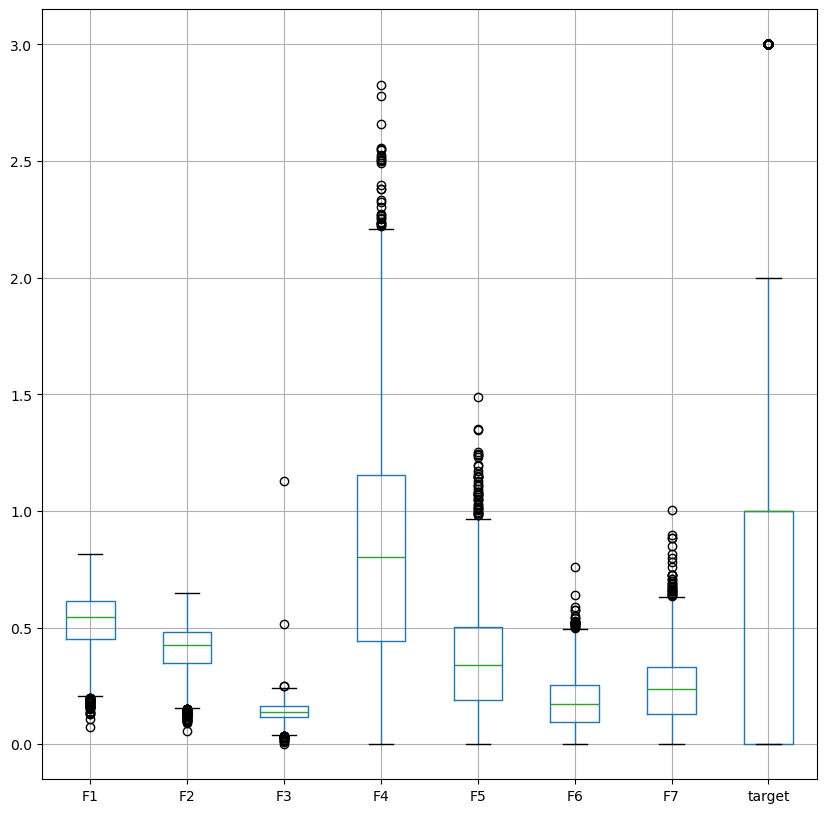

In [9]:
df0.boxplot(figsize=(10,10))
plt.show()

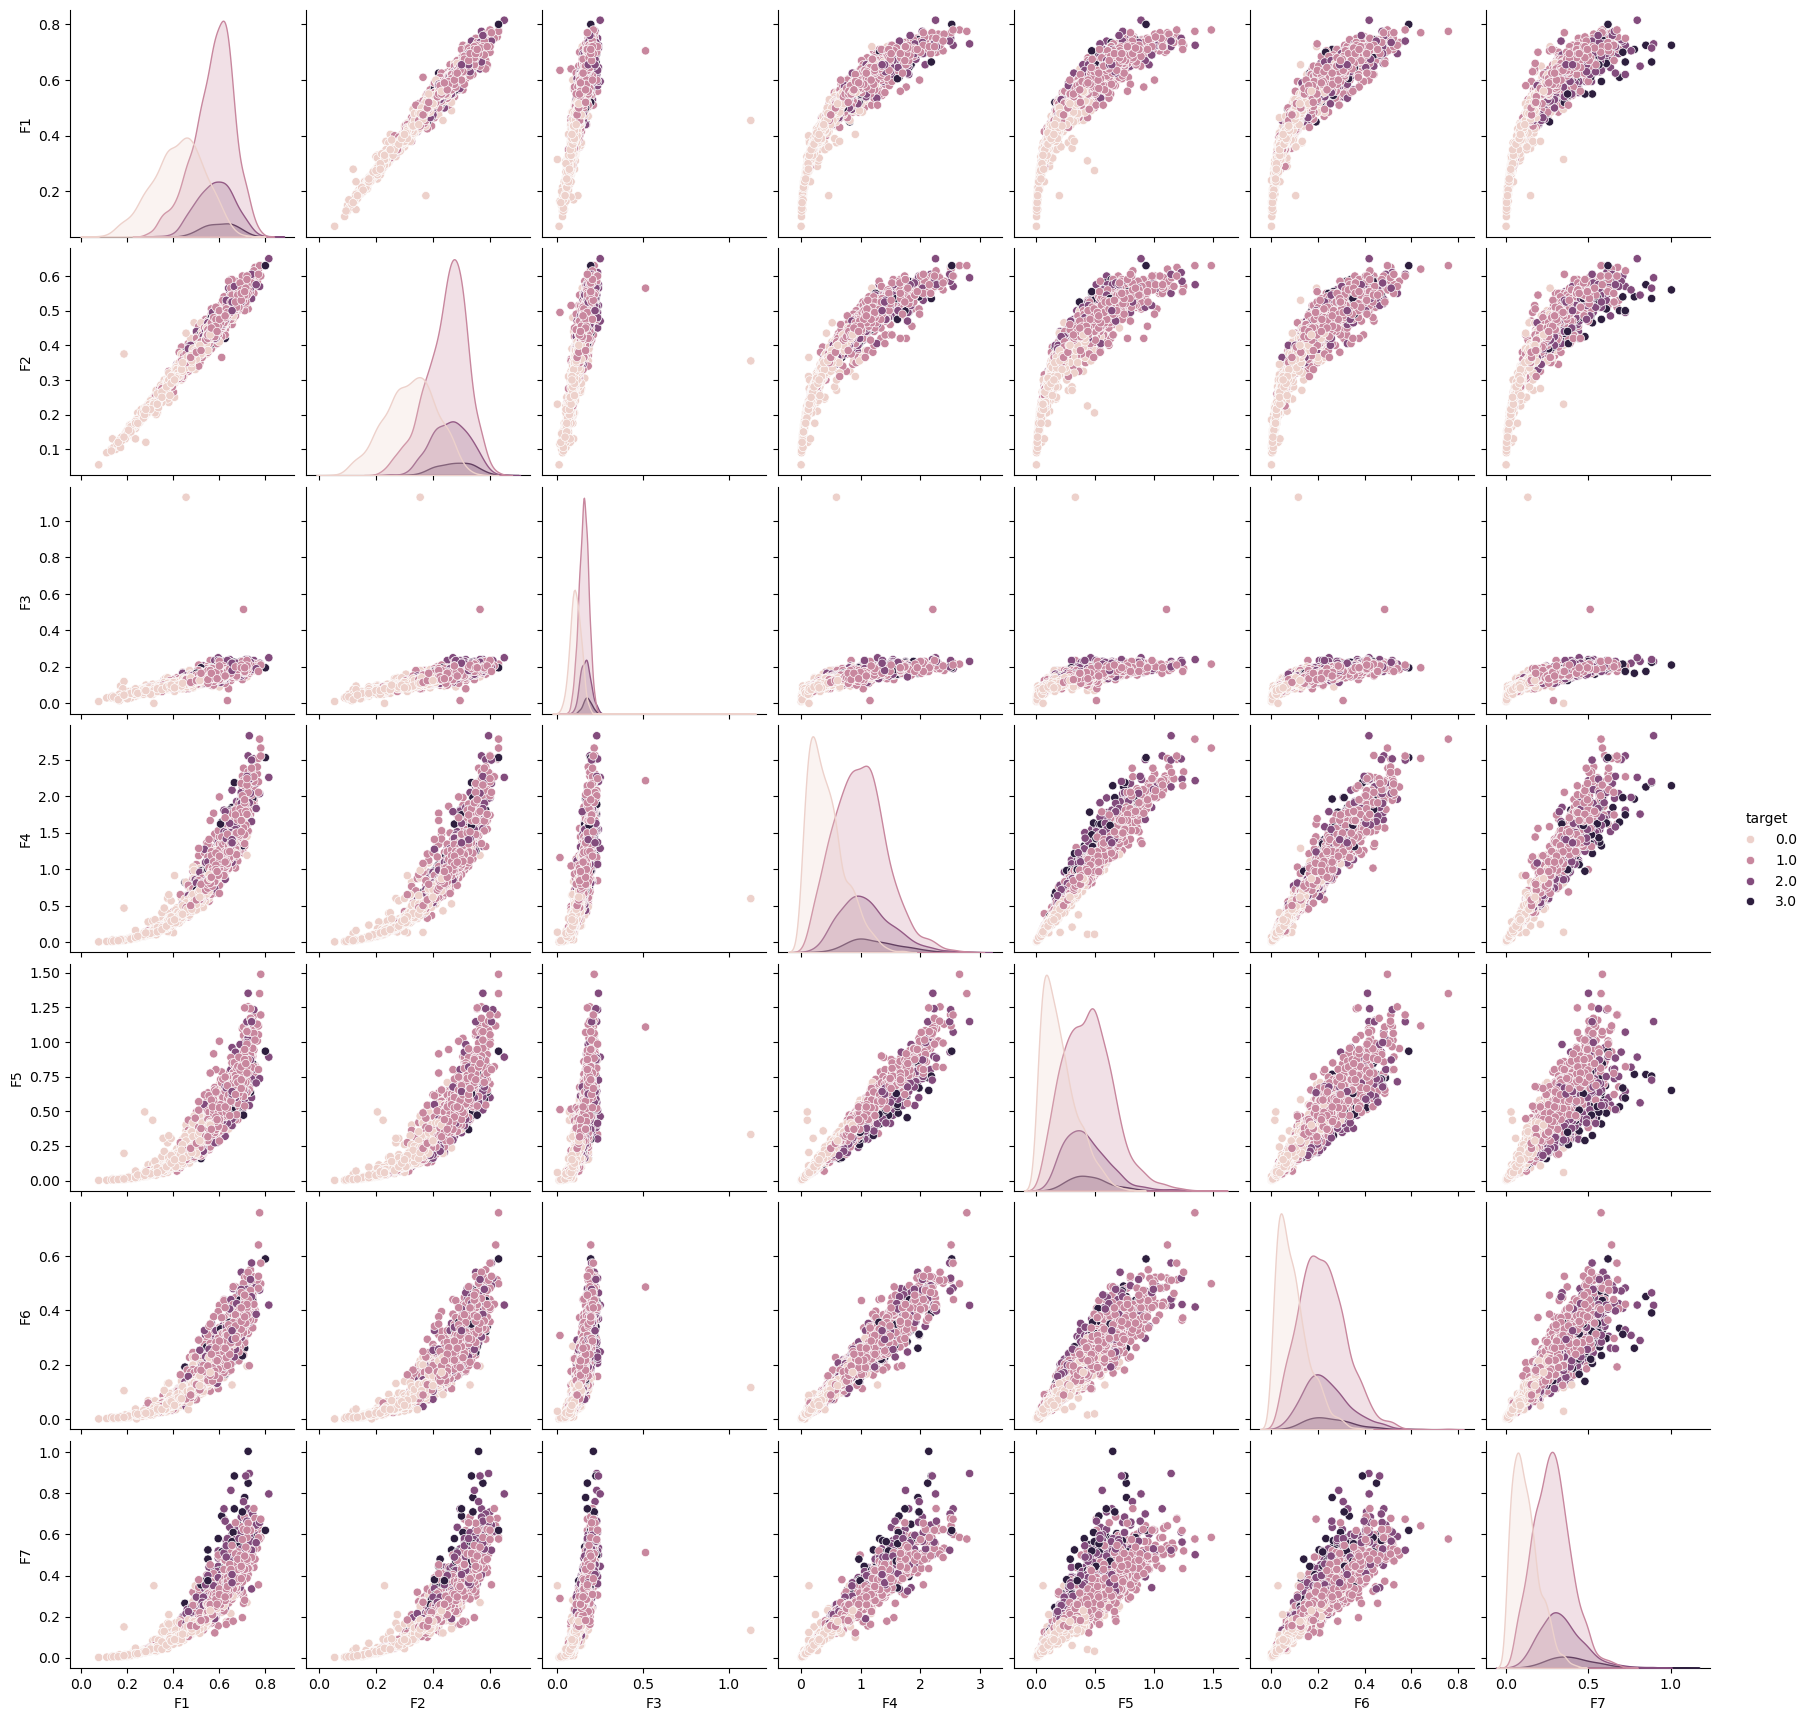

In [10]:
sns.pairplot(df0, hue=target)
plt.show()

As we've mentioned, this dataset has a set of peculiarities.

- The distributions are not balanced, since the some columns have very different interval ranges w.r.t. the others.
- Since we have a column with non-numerical values, we may need to apply some kind of value encoding.
- There are missing values in the dataset. This can be seen in the 'describe' step, in which some columns have less values than others. We may need to drop them.
- The distribution of data can be approximated by a curve for some pairs (i.e., (2,8), (2,5)) and by a line (linear distribution) for some others (i.e. (7,5), (6,5)).
- In the pairplots, we can see the presence of some outliers, since we have some values that are very much far from the others.

Before dropping any columns, we may first need to transform data properly. First, let's encode the values in the first column using a OrdinalEncoder.

In [80]:
from sklearn.preprocessing import  OneHotEncoder

df1 = df0.copy()
one = OneHotEncoder()
column_to_encode = 'Gender'
enc_data = one.fit_transform(df1[[column_to_encode]])
columns = one.categories_[0]
enc_df = pd.DataFrame(enc_data.toarray(),columns=columns)
df1 = df1.drop([column_to_encode], axis=1)
df1 = df1.join(enc_df)
df1.head()

,F1,F2,F3,F4,F5,F6,F7,target,F,I,M
0,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0,0.0,0.0,1.0
1,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0,0.0,0.0,1.0
2,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0,1.0,0.0,0.0
3,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0,0.0,0.0,1.0
4,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0,0.0,1.0,0.0


Now, another important thing to do, is to deal with missing values. Simply, we drop them.

In [13]:
print("There are {} columns with missing values".format(df1.isna().sum().sum()))
df2 = df1.dropna()
print("There are {} columns with missing values".format(df2.isna().sum().sum()))

There are 1314 columns with missing values
There are 0 columns with missing values


In [82]:
from sklearn.preprocessing import LabelEncoder

target = 'target'
le = LabelEncoder()
y = le.fit_transform(df2[target])
X = df2.drop([target], axis=1)

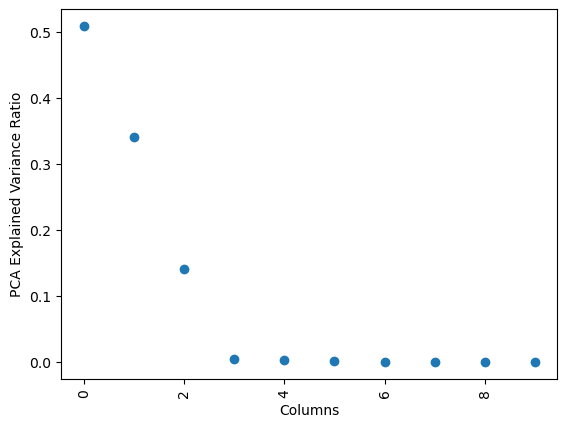

In [83]:
from sklearn.decomposition import PCA

pca = PCA()
X_trans = pca.fit_transform(X)
plt.scatter(range(X.shape[1]), pca.explained_variance_ratio_);

plt.xlabel('Columns')
plt.ylabel('PCA Explained Variance Ratio')

plt.xticks(rotation = 90)

plt.show()

In [92]:
cutoff_variance=0.99

cumulative_variances = np.cumsum(pca.explained_variance_ratio_.copy())

cumulative_variances

array([0.50905686, 0.84968677, 0.99099389, 0.99494448, 0.99776162,
       0.99884228, 0.9994289 , 0.99985196, 1.        , 1.        ])

In [93]:
cutoff_index = np.argmax(cumulative_variances > cutoff_variance)
print("Used the top {} transformed variables".format(cutoff_index+1))
X_cut = X_trans[:, :cutoff_index+1]

Used the top 3 transformed variables


i don't cut anything using PCA, becouse 3 feature are nominal data converted with hot one encoder. and for those feature is normal to have low variance, that doesn't mean they have low importance.

there are also few feature so i don't need it

In [119]:
X_cut.shape

(3052, 3)

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

In [102]:
#dt
[{'max_depth': [*range(1,20)], 'class_weight':[None,'balanced']}]

#nb
[{'var_smoothing':[10**exp for exp in range(-3,-12,-1)]}]

#lp
[{'early_stopping': [True, False], 'class_weight':[None,'balanced']}]

#svc
[
    {'kernel':['rbf'], 'gamma': [1e-3,1e-4], 'C':[1,10,100]},
    {'kernel':['linear'], 'C':[1,10,100]} 
]

#knn
[{'n_neighbors': [*range(1,7)]}]


#adb
[{
    'n_estimator': [20,30,40,50],
    'learning_rate':[0.5,0.75,1,1.25,1.5]
}]

#rf
[{
    'max_depth':[*range(4,30,4)],
    'n_estimators':[*range(10,30,5)],
    'class_weight':{None,'balanced'}
}]




[{'max_depth': [4, 8, 12, 16, 20, 24, 28],
  'n_estimators': [10, 15, 20, 25],
  'class_weight': {None, 'balanced'}}]

In [114]:
model_lbls = [
    'dt',
    'rf',
]

models = {
    'dt': {
        'name': 'Decision Tree',
        'estimator': DecisionTreeClassifier(random_state=random_state),
        'param':[
            {'max_depth':[*range(1,20)], 'class_weight':[None,'balanced']}
        ]
    },
    'nb':{
        'name': 'Gaussian Nb',
        'esitmator': GaussianNB(),
        'param': [{
            'var_smoothing': [10**exp for exp in range(-3,-12,-1)]
        }]
    },
    'lp':{
        'name':'linear perceptron',
        'estimator': Perceptron(random_state=random_state),
        'param':[{
            'early_stopping':[False,True],
            'class_weight': [None, 'balanced']
        }]
    },
    'svc':{
        'name': 'support vector classifier',
        'estimator': SVC(random_state=random_state),
        'param':[
            {'kernel':['rbf'], 'C':[1,10,100], 'gamma':[1e-3,1e-4]},
            {'kernel':['linear'], 'C':[1,10,100]}
        ]
    },
    'knn': {
        'name': 'K nearest neighbors',
        'estimator': KNeighborsClassifier(),
        'param': [
            {'n_neighbors':[*range(1,7)]}
        ],
    },
    'rf':{
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(random_state=random_state),
        'param': [{
            'max_depth': [*range(4,30,4)],
            'n_estimators': [*range(10,30,5)],
            'class_weight': [None, 'balanced']
        }]
    },
    'adb':{
        'name': 'Ada Boost',
        'estimator': AdaBoostClassifier(random_state=random_state),
        'param':[{
            'n_estimators':[20,30,40,50],
            'leanring_rate':[0.5,0.75,1]
        }]
    }
}

In [106]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=random_state, train_size=0.7)

print(f'Train size {X_train.shape[0]}, Test size {X_test.shape[0]}')

Train size 2136, Test size 916


In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

clfs = []
results = pd.DataFrame(columns=['Model','Best Param', 'accuracy', 'f1_score', 'precision', 'recall'])

for m in model_lbls:
    clf = GridSearchCV(
        estimator=models[m]['estimator'],
        param_grid=models[m]['param'],
        scoring='f1_macro',
        cv = 3,
    )
    clf.fit(X_train,y_train)
    clfs.append(clf)
    y_pred = clf.predict(X_test)
    c_report = classification_report(y_true=y_test,y_pred=y_pred,zero_division=1,output_dict=True)

    results.loc[len(results)] = [
        models[m]['name'],
        clf.best_params_,
        c_report['accuracy'],
        c_report['macro avg']['f1-score'],
        c_report['macro avg']['precision'],
        c_report['macro avg']['recall'],
    ]

In [117]:
display(results.sort_values(by='f1_score', ascending=False))

,Model,Best Param,accuracy,f1_score,precision,recall
1,Random Forest,"{'class_weight': 'balanced', 'max_depth': 8, '...",0.655022,0.510245,0.509243,0.514780
0,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 15}",0.534934,0.419722,0.416130,0.424691


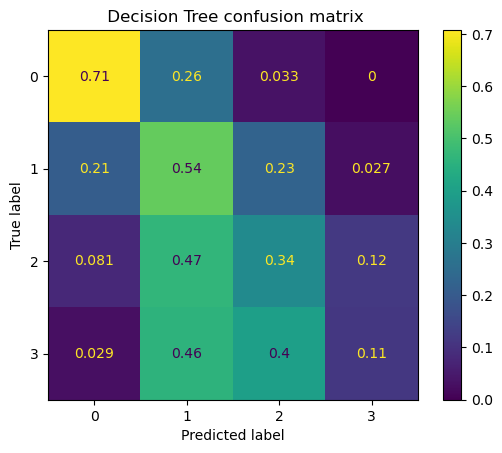

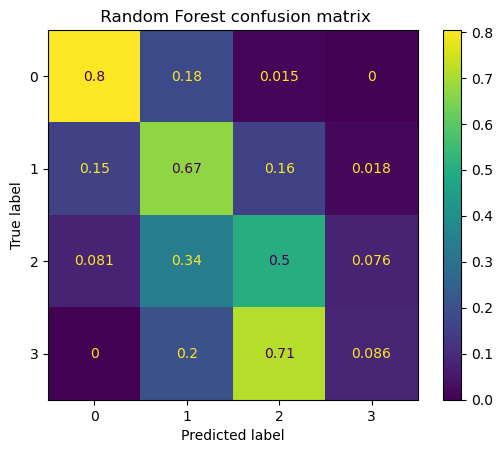

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay

for idx,m in enumerate(model_lbls):
    clf = clfs[idx]
    disp = ConfusionMatrixDisplay.from_estimator(estimator=clf, X=X_test, y=y_test, normalize='true')
    disp.ax_.set_title(f' {models[m]['name']} confusion matrix')

plt.show()